# Tuning Degree Correlations
Step 1: Link Selection
Choose at random two links. Label the four nodes at the end of these two links with a, b, c, and d such that their degrees are ordered as ka≥kb≥kc≥kd <br>
Step 2: Rewiring
Break the selected links and rewire them to form new pairs. Depending on the desired degree correlations the rewiring is done in two ways:<br>
Step 2A: Assortative
By pairing the two highest degree nodes (a with b) and the two lowest degree nodes (c/ with d), we connect nodes with comparable degrees, enhancing the network’s assortative nature.<br>
Step 2B: Disassortative
By pairing the highest and the lowest degree nodes (a with d and b with c), we connect nodes with different degrees, enhancing the network’s disassortative nature.

###### The main ideia is that rewiring the edges we keep the same degree distribution, but inscrease or decrease de assortativity

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statistics as st
import numpy as np
import random as rd
import itertools 

# Functions

In [2]:
#Avarage Neighbors Degree
def averageNeighborsDegree(G,node):
    neighbors=list(nx.neighbors(G,node))
    if(len(neighbors)==0):
        return 0 
    else:
        return sum([nx.degree(G,n) for n in neighbors])/len(neighbors)

def averageNeighborsDegreeByDegree(G,ylim=(0,0),xlim=(0,0)):
    #Get only the Largest Connect Component
    #G = nx.subgraph(G,max(nx.connected_components(G),key=len))
    nodeWithDegreeK={}
    #Get the nodes with degree 'k'
    for node,k in dict(G.degree).items():
        if k not in nodeWithDegreeK:
            nodeWithDegreeK[k]=[node]
        else:
            nodeWithDegreeK[k].append(node)
    #Get the average neighbors degree for every node with degree'k'
    for k in nodeWithDegreeK:
        means=0
        for node in nodeWithDegreeK[k]:
            means+=averageNeighborsDegree(G,node)
        nodeWithDegreeK[k]=round(means/len(nodeWithDegreeK[k]),2)

    #Plot the distribution
    plt.figure(figsize=(6,6))
    plt.loglog(list(nodeWithDegreeK.keys()),list(nodeWithDegreeK.values()),'o',color='rebeccapurple')
    #check the scale (custom ou default)
    if ylim==(0,0) or xlim==(0,0):
        ylim=plt.gca().get_ylim()
        xlim=plt.gca().get_xlim()

    #Plot the line for a random prediction
    degree = list(dict(G.degree).values())
    neutralNetwork=round((st.variance(degree) + st.mean(degree)**2)/st.mean(degree),2)
    randomPrediction=[neutralNetwork for x in range(int(xlim[1])+2)]    
    
    plt.loglog(range(int(xlim[1])+2),randomPrediction,'-',color='black')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('K',fontsize=16)
    plt.ylabel(r'$K_n$'r'$_n$(K)',rotation = 0,fontsize=16)
    plt.title(G.name+'\n'+'Assortativity Coefficient: '+str(round(nx.assortativity.degree_assortativity_coefficient(G),2)))
    plt.show()
    
def numberOfDegrees(G):
    numberOfDegreeK={}
    #Get the nodes with degree 'k'
    for node,k in dict(G.degree).items():
        if k not in numberOfDegreeK:
            numberOfDegreeK[k]=1
        else:
            numberOfDegreeK[k]+=1
    
    ordem = sorted(numberOfDegreeK.items())
    ordem = sorted(ordem, key=lambda x:x[1],reverse=True)
    plt.plot(sorted(dict(G.degree).values()),'.')
    plt.title('Distribuição de grau')
    plt.show()


In [203]:
def rewireIncreaseAssortativity(G_original,loops=10): 
    #Create a graph without edges, but with all nodes
    G = nx.Graph()
    for n in list(G_original.nodes):
        G.add_node(n)

    degreeOriginal = dict(G_original.degree)
    nodesByDegreeDesc = sorted(degreeOriginal.items(),key=lambda x:x[1],reverse=True)

    #Only the node label with degree > 0, sorted by degree Desc
    hubFirst = [t[0] for t in nodesByDegreeDesc if(t[1])>0]

    #The algorithm heart! Keep track of how many neighbors each node can add
    remainingDegreePerNode = dict(nodesByDegreeDesc)

    # remainingNodes=[]

    #Start from the biggest to the smallest, removing it from the list
    while(len(hubFirst)>0):
        n1 = hubFirst.pop(0)
        edgesToAdd = remainingDegreePerNode[n1]
        firstAux=0
        #This node may have new neighbors?
        while(edgesToAdd>0): 
            #this will only happen when n1 have degree remaing, but no available neighbor
            #force the next node OR end
            if(firstAux > len(hubFirst) or len(hubFirst)==0):
                edgesToAdd=0 
            else:
                #get the smallest available node to become n1 neighbor
                n2 = hubFirst[firstAux]#the last elem 
                if(remainingDegreePerNode[n2]>0):
                    G.add_edge(n1,n2)
                    #n2 has one less available neighbor
                    remainingDegreePerNode[n2]-=1
                    #n1 has one less available neighbor
                    remainingDegreePerNode[n1]-=1
                    edgesToAdd-=1
                    #need to change n2. move the 'pointer' one to the left
                    firstAux+=1
                else:
                    hubFirst.remove(n2)

    print("Remaining Degree Per Node:")                
    print([t for t in remainingDegreePerNode.items() if(t[1]>0)])

    #     nx.draw_kamada_kawai(G,with_labels=1)
    #     plt.show()
    return G

In [205]:
def rewireDecreaseAssortativity(G_original):
    #Create a graph without edges, but with all nodes
    G = nx.Graph()
    for n in list(G_original.nodes):
        G.add_node(n)

    degreeOriginal = dict(G_original.degree)
    nodesByDegreeDesc = sorted(degreeOriginal.items(),key=lambda x:x[1],reverse=True)

    #Only the node label with degree > 0, sorted by degree Desc
    hubFirst = [t[0] for t in nodesByDegreeDesc if(t[1])>0]

    #The algorithm heart! Keep track of how many neighbors each node can add
    remainingDegreePerNode = dict(nodesByDegreeDesc)

    #Start from the biggest to the smallest, removing it from the list
    while(len(hubFirst)>0):
        n1 = hubFirst.pop(0)
        edgesToAdd = remainingDegreePerNode[n1]
        lastAux=-1
        #This node may have new neighbors?
        while(edgesToAdd>0): 
            #this will only happen when n1 have degree remaing, but no available neighbor
            #force the next node OR end
            if(abs(lastAux) > len(hubFirst) or len(hubFirst)==0):
                edgesToAdd=0 
            else:
                #get the smallest available node to become n1 neighbor
                n2 = hubFirst[lastAux]#the last elem 
                if(remainingDegreePerNode[n2]>0):
                    G.add_edge(n1,n2)
                    #n2 has one less available neighbor
                    remainingDegreePerNode[n2]-=1
                    #n1 has one less available neighbor
                    remainingDegreePerNode[n1]-=1
                    edgesToAdd-=1
                    #need to change n2. move the 'pointer' one to the left
                    lastAux-=1
                else:
                    hubFirst.remove(n2)

    #     nx.draw_kamada_kawai(G,with_labels=1)
    #     plt.show()

    print("Remaining Degree Per Node:")                
    print([t for t in remainingDegreePerNode.items() if(t[1]>0)])      
    return G              

# INPUT

In [207]:
metabolic=nx.read_edgelist('datasets/NetworkScienceBook_metabolic.edgelist.txt')
collaboration=nx.read_edgelist('datasets/NetworkScienceBook_collaboration.edgelist.txt')
powergrid=nx.read_edgelist('datasets/NetworkScienceBook_powergrid.edgelist.txt')
reactome=nx.from_pandas_edgelist(pd.read_csv('datasets/ProteinProteinInteractionNetwork_reactomeFI2019.tsv',sep='\t'),source='Gene1',target='Gene2')

barabasi = nx.barabasi_albert_graph(10000,3)

testGraph = nx.Graph()
start=0
end=3
for i in range(1,10):
    start=end
    end+=i
    testGraph = nx.compose(testGraph,nx.star_graph(range(start,end)))
    testGraph.add_edge(1,start)    
testGraph.remove_node(end-1)

barbell = nx.barbell_graph(5,4)
barbell.remove_node(10)

random = nx.erdos_renyi_graph(10000,0.0006)

# Rewiring

Name: 
Type: Graph
Number of nodes: 23133
Number of edges: 93439
Average degree:   8.0784


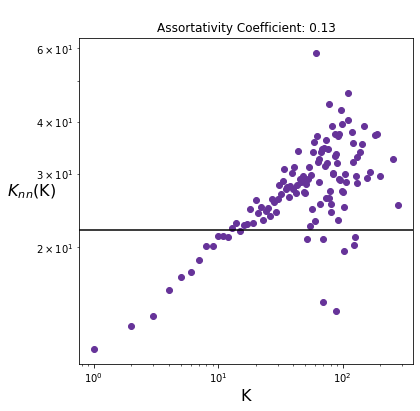

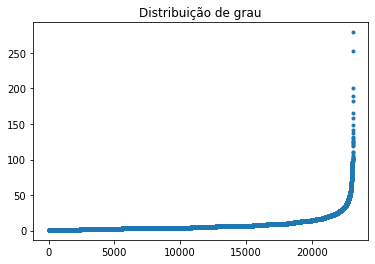

CCs 567


In [237]:
original = collaboration

print(nx.info(original))
averageNeighborsDegreeByDegree(original)
numberOfDegrees(original)
# nx.draw_kamada_kawai(original,with_labels=1)
# plt.show()   
print('CCs',len(list(nx.connected_components(original))))

Remaining Degree Per Node:
[('639', 8), ('13940', 7), ('12152', 7), ('14121', 4)]
Name: 
Type: Graph
Number of nodes: 23133
Number of edges: 93426
Average degree:   8.0773


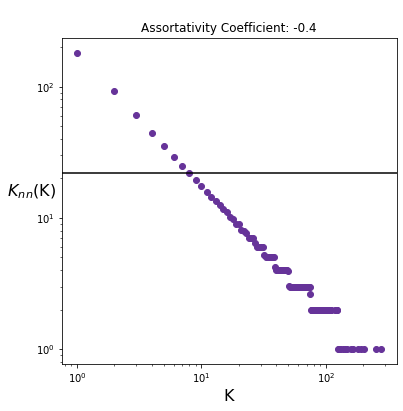

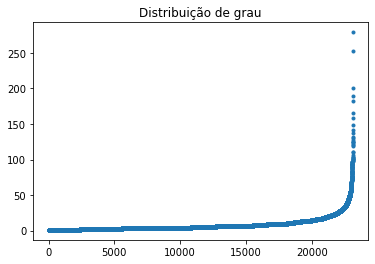

CCs 31


In [238]:
G = rewireDecreaseAssortativity(original)
print(nx.info(G))
averageNeighborsDegreeByDegree(G)
numberOfDegrees(G)
# nx.draw_kamada_kawai(G,with_labels=1)
# plt.show()
print('CCs',len(list(nx.connected_components(G))))

Remaining Degree Per Node:
[]
Name: 
Type: Graph
Number of nodes: 23133
Number of edges: 93439
Average degree:   8.0784


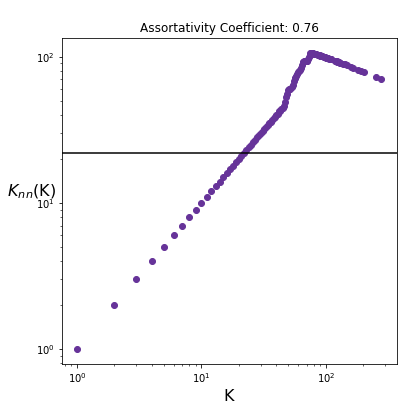

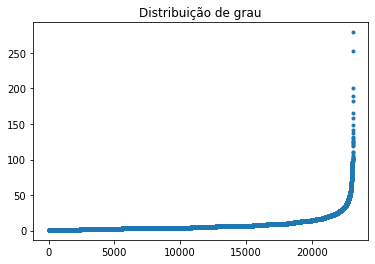

CCs 1431


In [239]:
G = rewireIncreaseAssortativity(original)
print(nx.info(G))
averageNeighborsDegreeByDegree(G)
numberOfDegrees(G)
# nx.draw_kamada_kawai(G,with_labels=1)
# plt.show()
print('CCs',len(list(nx.connected_components(G))))